In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.precision = 3
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.titlesize'] = 15

%matplotlib inline

# Loading The Files

In [12]:
# Load 'Movies' file
movies = pd.read_csv('/Users/orgranot/Downloads/movies_metadata.csv', 
                     usecols=['budget', 'genres', 'id', 'original_language', 'original_title', 
                              'popularity', 'production_companies', 'production_countries', 
                              'release_date', 'runtime'], low_memory=False)

movies.id = movies.id.str.replace('-', '0').astype('int')
movies.release_date = pd.to_datetime(movies.release_date, errors='coerce')
movies['year'] = movies.release_date.dt.year
movies['month'] = movies.release_date.dt.month
movies = movies.drop(['release_date'], axis=1)
movies = movies[~movies.id.duplicated()]

# Load 'Credits' file
credits = pd.read_csv('/Users/orgranot/Downloads/credits.csv', usecols=['id', 'crew', 'cast'])
credits = credits[~credits.id.duplicated()]

# Load 'keywords' file
keywords = pd.read_csv('/Users/orgranot/Downloads/keywords.csv')
keywords = keywords[~keywords.id.duplicated()]

# Load 'tags' file
tags = pd.read_csv('/Users/orgranot/Downloads/ml-latest/tags.csv', usecols=['movieId', 'tag'])

# Load 'links' file
links = pd.read_csv('/Users/orgranot/Downloads/ml-latest/links.csv')
links = links.loc[links.tmdbId.notnull()]
links.tmdbId = links.tmdbId.astype('int')

In [13]:
clean_movies = movies.drop(['budget', 'popularity', 'runtime', 'year', 'month'], axis=1)
print(f"Number of unique movies: {len(clean_movies.id.unique())}")
clean_movies.head()

Number of unique movies: 45436


,genres,id,original_language,original_title,production_companies,production_countries
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o..."
4,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o..."


In [14]:
print(f"Number of unique movies: {len(credits.id.unique())}")
credits.head()

Number of unique movies: 45432


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [15]:
print("Movies appears in 'celan_movies', but not in 'credits': ")
print(set(clean_movies.id.unique())^set(credits.id.unique()))

Movies appears in 'celan_movies', but not in 'credits': 
{401840, 2012009029, 2014001001, 1997008020}


# Merging

In [16]:
metadata = pd.merge(left=clean_movies, right=credits, on='id')

metadata = metadata.merge(keywords, on='id')

metadata_links = pd.merge(left=metadata, right=links, left_on='id', right_on='tmdbId')

tags_per_movie = tags.groupby('movieId')['tag'].apply(list).reset_index(drop=False)

metadata_all = pd.merge(left=metadata_links, right=tags_per_movie, on='movieId')
metadata_all = metadata_all.drop(['tmdbId', 'movieId', 'imdbId'], axis=1)

# Data Cleaning

In [17]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [18]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [19]:
def create_soup(x, dir_weight=0):
    
    return ' '.join(x['keywords']) + ' ' + \
           ' '.join(x['cast']) + ' ' + \
           ' '.join(x['tag']) + ' ' + \
           ' '.join(x['genres']) + ' ' + \
            ' '.join(x['production_companies']) + ' ' + \
            ' '.join(x['production_countries']) + ' ' + \
            x['director'] + (' ' + x['director'])*4

## Extracting Lists

In [20]:
features_to_clean = ['genres', 'production_companies', 'production_countries', 'crew', 'cast', 'keywords']

for feature in features_to_clean:
    metadata_all[feature] = metadata_all[feature].fillna('[]')
    metadata_all[feature] = metadata_all[feature].apply(literal_eval)
    if feature == 'crew':
        metadata_all['director'] = metadata_all[feature].apply(get_director)
        metadata_all = metadata_all.drop([feature], axis=1)
    else:
        metadata_all[feature] = metadata_all[feature].apply(get_list)

## Remove Spaces & Make Strings Lower

In [21]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [22]:
def clean_tags(tags_list):
    
    tags_list = list(set(tags_list))
    res = []
    for tag in tags_list:
        try:
            temp = tag.replace(' ', '').lower()
        except AttributeError:
            temp = ''
        
        res.append(temp)
    
    return res

In [23]:
features_to_clean = ['genres', 'production_companies', 'production_countries', 
                     'cast', 'keywords', 'director', 'tag']

for feature in features_to_clean:
    
    if feature == 'tag':
        metadata_all[feature] = metadata_all[feature].apply(clean_tags)
    else:
        metadata_all[feature] = metadata_all[feature].apply(clean_data)

## Create Bag-of-Words

In [24]:
metadata_all['bow'] = metadata_all.apply(create_soup, axis=1)

# Recommend

In [25]:
def get_recommendations(title, ind_movies, cosine_sim, top_n=10):
    # Get the index of the movie that matches the title
    idx = ind_movies[title]
    if not isinstance(idx, np.int64):
        print("There is more then one movie with this title")
        print("Choosing only the first one...")
        idx = idx[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top_n most similar movies
    sim_scores = sim_scores[1:top_n+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    similarity_score = [round(i[1], 3) for i in sim_scores]

    # Return the top top_n most similar movies
    rec_movies = metadata_all['original_title'].iloc[movie_indices].values
    return dict(zip(rec_movies, similarity_score))
#     return metadata_all['original_title'].iloc[movie_indices], sim_scores, movie_indices

## Build Similarity Matrix

In [26]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata_all['bow'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

## Final Output

In [27]:
indices = pd.Series(metadata_all.index, index=metadata_all['original_title'])

get_recommendations('Inception', indices, cosine_sim, top_n=10)

{'Interstellar': 0.401,
 'Dunkirk': 0.384,
 'The Prestige': 0.38,
 'The Dark Knight': 0.366,
 'Doodlebug': 0.348,
 'Following': 0.34,
 'Batman Begins': 0.331,
 'Insomnia': 0.322,
 'Memento': 0.316,
 'The Dark Knight Rises': 0.309}

In [35]:
! pip3 install matrix_factorization

  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-py3-none-any.whl size=16467 sha256=6d6dfa5a37eef8b43e2af0f441fd96de0d02d2eee2d23d9264fa2983fe94a9cb
  Stored in directory: /Users/orgranot/Library/Caches/pip/wheels/f8/eb/f9/65e67559744aed25dda41e09ced4f5ca64a5ef56e67d7dba16
Successfully built matrix-factorization


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from surprise import Reader, SVD, Dataset
from surprise.model_selection.validation import cross_validate
from matrix_factorization import KernelMF
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [43]:
movies_df = pd.read_csv('/Users/orgranot/Downloads/cleaned_movies.csv')
ratings_df = pd.read_csv('/Users/orgranot/Downloads/ratings.csv')


In [44]:
movies_df.head(10)

,Unnamed: 0,budget,genres,id,imdb_id,original_title,production_companies,revenue,runtime,spoken_languages,title,vote_count,release_year,cast,keywords,director
0,0,30000000,"['Animation', 'Comedy', 'Family']",862,tt0114709,Toy Story,['Pixar Animation Studios'],3.736e+08,81.0,['English'],Toy Story,5415.0,1995,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousy', 'toy', 'boy']",John Lasseter
1,1,65000000,"['Adventure', 'Fantasy', 'Family']",8844,tt0113497,Jumanji,"['TriStar Pictures', 'Teitler Film', 'Intersco...",2.628e+08,104.0,"['English', 'Français']",Jumanji,2413.0,1995,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board game', 'disappearance', ""based on chil...",Joe Johnston
2,2,0,"['Romance', 'Comedy']",15602,tt0113228,Grumpier Old Men,"['Warner Bros.', 'Lancaster Gate']",0.000e+00,101.0,['English'],Grumpier Old Men,92.0,1995,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret']","['fishing', 'best friend', 'duringcreditssting...",Howard Deutch
3,3,16000000,"['Comedy', 'Drama', 'Romance']",31357,tt0114885,Waiting to Exhale,['Twentieth Century Fox Film Corporation'],8.145e+07,127.0,['English'],Waiting to Exhale,34.0,1995,"['Whitney Houston', 'Angela Bassett', 'Loretta...","['based on novel', 'interracial relationship',...",Forest Whitaker
4,4,0,['Comedy'],11862,tt0113041,Father of the Bride Part II,"['Sandollar Productions', 'Touchstone Pictures']",7.658e+07,106.0,['English'],Father of the Bride Part II,173.0,1995,"['Steve Martin', 'Diane Keaton', 'Martin Short']","['baby', 'midlife crisis', 'confidence']",Charles Shyer
5,5,60000000,"['Action', 'Crime', 'Drama']",949,tt0113277,Heat,"['Regency Enterprises', 'Forward Pass', 'Warne...",1.874e+08,170.0,"['English', 'Español']",Heat,1886.0,1995,"['Al Pacino', 'Robert De Niro', 'Val Kilmer']","['robbery', 'detective', 'bank']",Michael Mann
6,6,58000000,"['Comedy', 'Romance']",11860,tt0114319,Sabrina,"['Paramount Pictures', 'Scott Rudin Production...",0.000e+00,127.0,"['Français', 'English']",Sabrina,141.0,1995,"['Harrison Ford', 'Julia Ormond', 'Greg Kinnear']","['paris', 'brother brother relationship', 'cha...",Sydney Pollack
7,7,0,"['Action', 'Adventure', 'Drama']",45325,tt0112302,Tom and Huck,['Walt Disney Pictures'],0.000e+00,97.0,"['English', 'Deutsch']",Tom and Huck,45.0,1995,"['Jonathan Taylor Thomas', 'Brad Renfro', 'Rac...",[],Peter Hewitt
8,8,35000000,"['Action', 'Adventure', 'Thriller']",9091,tt0114576,Sudden Death,"['Universal Pictures', 'Imperial Entertainment...",6.435e+07,106.0,['English'],Sudden Death,174.0,1995,"['Jean-Claude Van Damme', 'Powers Boothe', 'Do...","['terrorist', 'hostage', 'explosive']",Peter Hyams
9,9,58000000,"['Adventure', 'Action', 'Thriller']",710,tt0113189,GoldenEye,"['United Artists', 'Eon Productions']",3.522e+08,130.0,"['English', 'Pусский', 'Español']",GoldenEye,1194.0,1995,"['Pierce Brosnan', 'Sean Bean', 'Izabella Scor...","['cuba', 'falsely accused', 'secret identity']",Martin Campbell


In [45]:
movies_df.shape

(29424, 16)

In [46]:
ratings_df.shape

(100836, 4)

In [55]:
df=ratings_df.merge(movies_df[['id','original_title']],how='inner', left_on='movieId', right_on='id')
df.head(10)

,userId,movieId,rating,timestamp,id,original_title
0,1,6,4.0,964982224,6,Judgment Night
1,6,6,4.0,845553757,6,Judgment Night
2,11,6,5.0,902154266,6,Judgment Night
3,18,6,4.0,1460138360,6,Judgment Night
4,23,6,4.0,1107342267,6,Judgment Night
5,24,6,4.5,1458941767,6,Judgment Night
6,28,6,3.5,1234570483,6,Judgment Night
7,32,6,3.0,856736172,6,Judgment Night
8,44,6,3.0,869251910,6,Judgment Night
9,45,6,4.0,1121724608,6,Judgment Night


In [56]:
df = df.drop_duplicates()

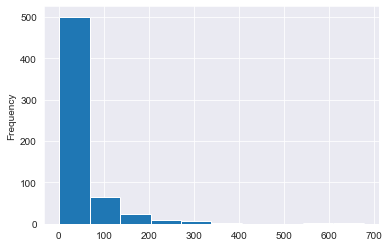

In [57]:
df['userId'].value_counts().plot(kind='hist')

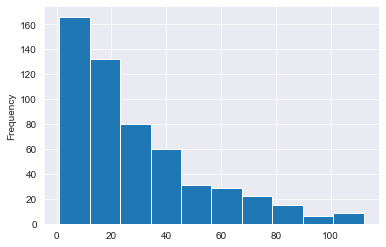

In [58]:
df['userId'].value_counts()[-550:].plot(kind='hist')

In [59]:
df

,userId,movieId,rating,timestamp,id,original_title
0,1,6,4.0,964982224,6,Judgment Night
1,6,6,4.0,845553757,6,Judgment Night
2,11,6,5.0,902154266,6,Judgment Night
3,18,6,4.0,1460138360,6,Judgment Night
4,23,6,4.0,1107342267,6,Judgment Night
...,...,...,...,...,...,...
28638,610,80094,4.0,1493848484,80094,Hra o jablko
28639,610,89072,4.0,1493848545,89072,Ginger
28640,610,93193,3.0,1493850013,93193,Jigsaw
28641,610,114044,3.5,1493848721,114044,Interkosmos


In [60]:
df['count']=df['userId'].map(df['userId'].value_counts())
df = df.rename(columns={"userId":"user_id", "movieId":"item_id"})
df_10 = df[df['count']>10]
df_5 = df[df['count']>5]
df_50 = df[df['count']>50]
df_20 = df[df['count']>20]

In [61]:
X = df_10[['user_id','item_id']]
y = df_10['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_10['user_id'])

In [62]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0086364733138267
Epoch  2 / 200  -  train_rmse: 0.9848412720637713
Epoch  3 / 200  -  train_rmse: 0.966044288661804
Epoch  4 / 200  -  train_rmse: 0.9506413213858357
Epoch  5 / 200  -  train_rmse: 0.9375970905222999
Epoch  6 / 200  -  train_rmse: 0.9263391443566951
Epoch  7 / 200  -  train_rmse: 0.9164535907007556
Epoch  8 / 200  -  train_rmse: 0.9076564630228536
Epoch  9 / 200  -  train_rmse: 0.8997314928242323
Epoch  10 / 200  -  train_rmse: 0.8925192266066362
Epoch  11 / 200  -  train_rmse: 0.8858988115931976
Epoch  12 / 200  -  train_rmse: 0.879771374564335
Epoch  13 / 200  -  train_rmse: 0.8740646029122914
Epoch  14 / 200  -  train_rmse: 0.8687163694288931
Epoch  15 / 200  -  train_rmse: 0.8636753914830422
Epoch  16 / 200  -  train_rmse: 0.858907701084045
Epoch  17 / 200  -  train_rmse: 0.8543743306386997
Epoch  18 / 200  -  train_rmse: 0.8500492785364494
Epoch  19 / 200  -  train_rmse: 0.8459092590381924
Epoch  20 / 200  -  train_rmse: 0.841931021

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [63]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_10 = (rmse, r2)
metrics_mf_10

(0.8908413562858296, 0.26841788382977194)

In [64]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [65]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [66]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'test_rmse': array([0.86902072, 0.88681259, 0.86640779, 0.88976231, 0.87924807]),
 'test_mae': array([0.67542446, 0.68739895, 0.67389796, 0.68178108, 0.67898049]),
 'fit_time': (2.045725107192993,
  2.2056987285614014,
  1.6036181449890137,
  2.030172109603882,
  1.9789910316467285),
 'test_time': (0.4513061046600342,
  0.05280709266662598,
  0.03628420829772949,
  0.0863332748413086,
  0.03939104080200195)}

In [67]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [68]:
y_pred = []
for line in range(len(X_test)):
    y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_10 = (rmse, r2)
metrics_svd_10

(0.87377114924666, 0.29618625979544577)

In [69]:
X = df_5[['user_id','item_id']]
y = df_5['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_5['user_id'])

In [70]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0177974707447068
Epoch  2 / 200  -  train_rmse: 0.9935666407242241
Epoch  3 / 200  -  train_rmse: 0.9744850017022648
Epoch  4 / 200  -  train_rmse: 0.9588066993964024
Epoch  5 / 200  -  train_rmse: 0.9455936578142929
Epoch  6 / 200  -  train_rmse: 0.9342032961732138
Epoch  7 / 200  -  train_rmse: 0.9242321917242028
Epoch  8 / 200  -  train_rmse: 0.9153623547690641
Epoch  9 / 200  -  train_rmse: 0.9073702326503702
Epoch  10 / 200  -  train_rmse: 0.9001021041579248
Epoch  11 / 200  -  train_rmse: 0.8934350023761498
Epoch  12 / 200  -  train_rmse: 0.8872590721611504
Epoch  13 / 200  -  train_rmse: 0.8815049315691957
Epoch  14 / 200  -  train_rmse: 0.8761141615087362
Epoch  15 / 200  -  train_rmse: 0.8710293720751642
Epoch  16 / 200  -  train_rmse: 0.8662155525157185
Epoch  17 / 200  -  train_rmse: 0.8616423600867132
Epoch  18 / 200  -  train_rmse: 0.8572724194052977
Epoch  19 / 200  -  train_rmse: 0.8530863538113925
Epoch  20 / 200  -  train_rmse: 0.849064

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [71]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_5 = (rmse, r2)
metrics_mf_5

(0.8912834885715188, 0.23921742909052424)

In [72]:
df_train =  pd.concat([X_train, y_train], axis=1)

reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'test_rmse': array([0.88580063, 0.88947961, 0.8904328 , 0.87536571, 0.87809171]),
 'test_mae': array([0.68640185, 0.69153442, 0.6858767 , 0.67060675, 0.67861779]),
 'fit_time': (1.4966890811920166,
  2.2324306964874268,
  1.7726728916168213,
  2.0094029903411865,
  2.187114953994751),
 'test_time': (0.057893991470336914,
  0.04312419891357422,
  0.0748589038848877,
  0.036364078521728516,
  0.06193995475769043)}

In [73]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [74]:
y_pred = []
for line in range(len(X_test)):
    y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_5 = (rmse, r2)
metrics_svd_5

(0.8682083588720827, 0.27810047177226516)

In [75]:
X = df_50[['user_id','item_id']]
y = df_50['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_50['user_id'])

In [76]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 0.9937403630775791
Epoch  2 / 200  -  train_rmse: 0.970878989726379
Epoch  3 / 200  -  train_rmse: 0.9527447672297545
Epoch  4 / 200  -  train_rmse: 0.9376743920841993
Epoch  5 / 200  -  train_rmse: 0.9247976163136415
Epoch  6 / 200  -  train_rmse: 0.9135908573439413
Epoch  7 / 200  -  train_rmse: 0.903699439158772
Epoch  8 / 200  -  train_rmse: 0.8948569027095192
Epoch  9 / 200  -  train_rmse: 0.8868747040159788
Epoch  10 / 200  -  train_rmse: 0.8796095490786321
Epoch  11 / 200  -  train_rmse: 0.8729551529588141
Epoch  12 / 200  -  train_rmse: 0.8668099170848047
Epoch  13 / 200  -  train_rmse: 0.8610983875118586
Epoch  14 / 200  -  train_rmse: 0.8557612319225105
Epoch  15 / 200  -  train_rmse: 0.8507490809748535
Epoch  16 / 200  -  train_rmse: 0.8460233291670766
Epoch  17 / 200  -  train_rmse: 0.8415385295719109
Epoch  18 / 200  -  train_rmse: 0.8372705666154656
Epoch  19 / 200  -  train_rmse: 0.8331905279727869
Epoch  20 / 200  -  train_rmse: 0.82927766

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [77]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_50 = (rmse, r2)
metrics_mf_50

(0.8674316637697282, 0.2749594779555129)

In [78]:
df_train =  pd.concat([X_train, y_train], axis=1)

reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'test_rmse': array([0.85738275, 0.8759611 , 0.86559115, 0.84735009, 0.85350167]),
 'test_mae': array([0.66904146, 0.67824121, 0.67020022, 0.6561461 , 0.65647696]),
 'fit_time': (1.379641056060791,
  1.454758882522583,
  1.1637837886810303,
  1.3082029819488525,
  1.1722650527954102),
 'test_time': (0.027493000030517578,
  0.06693816184997559,
  0.07546091079711914,
  0.02408599853515625,
  0.022904157638549805)}

In [79]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [80]:
y_pred = []
for line in range(len(X_test)):
    y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_50 = (rmse, r2)
metrics_svd_50

(0.8476273641955087, 0.30768829411022736)

In [81]:
df_20 = df[df['count']>20]
X = df_20[['user_id','item_id']]
y = df_20['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0105768399358541
Epoch  2 / 200  -  train_rmse: 0.9869561584914457
Epoch  3 / 200  -  train_rmse: 0.9680916069591633
Epoch  4 / 200  -  train_rmse: 0.9524868427285419
Epoch  5 / 200  -  train_rmse: 0.9392053737208098
Epoch  6 / 200  -  train_rmse: 0.9276915614848554
Epoch  7 / 200  -  train_rmse: 0.9175677965954505
Epoch  8 / 200  -  train_rmse: 0.9085333649216165
Epoch  9 / 200  -  train_rmse: 0.9003969457858123
Epoch  10 / 200  -  train_rmse: 0.8929991659088667
Epoch  11 / 200  -  train_rmse: 0.886210383131671
Epoch  12 / 200  -  train_rmse: 0.8799380656890622
Epoch  13 / 200  -  train_rmse: 0.8741100371535239
Epoch  14 / 200  -  train_rmse: 0.8686562256695234
Epoch  15 / 200  -  train_rmse: 0.8635255927933716
Epoch  16 / 200  -  train_rmse: 0.8586761485317194
Epoch  17 / 200  -  train_rmse: 0.8540753955948849
Epoch  18 / 200  -  train_rmse: 0.8496912886378931
Epoch  19 / 200  -  train_rmse: 0.8455015363299975
Epoch  20 / 200  -  train_rmse: 0.8414824

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [82]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_20 = (rmse, r2)
metrics_mf_20

(0.897422562850779, 0.24733802752964074)

In [83]:
df_train =  pd.concat([X_train, y_train], axis=1)

reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'test_rmse': array([0.86644703, 0.86993027, 0.87930108, 0.87483646, 0.87774957]),
 'test_mae': array([0.67448952, 0.66673598, 0.68269939, 0.67702888, 0.67939608]),
 'fit_time': (1.5751497745513916,
  1.6598100662231445,
  1.7232849597930908,
  1.5627310276031494,
  1.928947925567627),
 'test_time': (0.06753897666931152,
  0.05016303062438965,
  0.04544210433959961,
  0.06644892692565918,
  0.03597903251647949)}

In [84]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [85]:
y_pred = []
for line in range(len(X_test)):
    y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_20 = (rmse, r2)
metrics_svd_20

(0.8723889985850106, 0.2887433071752763)

In [86]:
mins = [5,5,10,10,50,50,20,20]
methods = [0,1,0,1,0,1,0,1]
metrics = [metrics_mf_5,metrics_svd_5,metrics_mf_10, metrics_svd_10, metrics_mf_50, metrics_svd_50,metrics_mf_20, metrics_svd_20 ]
rmses = []
r2s = []
for met in metrics:
  rmses.append(met[0])
  r2s.append(met[1])

In [87]:
rmses

[0.8912834885715188,
 0.8682083588720827,
 0.8908413562858296,
 0.87377114924666,
 0.8674316637697282,
 0.8476273641955087,
 0.897422562850779,
 0.8723889985850106]

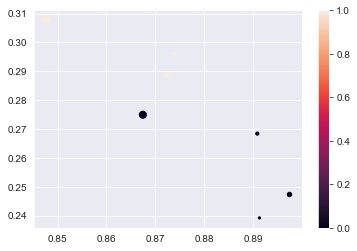

In [88]:
plt.scatter(x=rmses, y=r2s, s=mins, c=methods)
plt.colorbar()

In [89]:
# df_20 = df[df['count']>20]

# df_train, df_test = train_test_split(df_20, test_size=0.20, \
#                                                     random_state=1000, \
#                                     stratify = df_20['user_id'])

# factors = [100,200,500]
# epochs = [20,50,100]
# lr_all = [0.001,0.005,0.01]

# reader = Reader()
# data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
# rmse_20 = []
# r2_20 = []
# params = []
# for fac in factors:
#   for epoch in epochs:
#     for lr in lr_all:
#       svd = SVD(n_factors=fac, n_epochs=epoch, lr_all=lr)
#       cross_validate(svd, data, measures=['RMSE','MAE'])
#       trainset = data.build_full_trainset()
#       svd.fit(trainset)
#       y_pred = []
#       for line in range(len(df_test)):
#         y_pred.append(svd.predict(df_test.iloc[line,0],df_test.iloc[line,1],3)[3])
#       rmse_20.append(mean_squared_error(df_test['rating'], y_pred, squared=False))
#       r2_20.append(r2_score(df_test['rating'], y_pred))
#       params.append((fac,epoch,lr))



# np.argmin(rmse_20), np.argmax(r2_20), params[np.argmin(rmse_20)]

KeyboardInterrupt: 

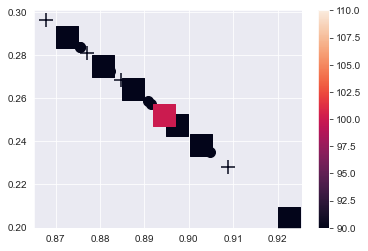

In [90]:
factors_plt = [100,100,100,100,100,100,100,100,100,200,200,200,200,200,200,200,200,200,500,500,500,500,500,500,500,500,500]
epochs_plt = [20,20,20,50,50,50,100,100,100,20,20,20,50,50,50,100,100,100,20,20,20,50,50,50,100,100,100]
marker_plt = ['o','o','o','o','o','o','o','o','o','+','+','+','+','+','+','+','+','+','s','s','s','s','s','s','s','s','s']
for _m, c, _s, _x, _y in zip(marker_plt, epochs_plt, factors_plt, rmse_20, r2_20):
    plt.scatter(_x, _y, marker=_m, c=c, s=_s)
# plt.scatter(x=rmse_20, y=r2_20, s=factors_plt, c=epochs_plt, marker=marker_plt)
plt.colorbar()

In [91]:
df_20 = df[df['count']>20]

df_train, df_test = train_test_split(df_20, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
svd = SVD(n_factors=500, n_epochs=100, lr_all=0.01)
cross_validate(svd, data, measures=['RMSE','MAE'])
trainset = data.build_full_trainset()
svd.fit(trainset)

In [92]:
def get_10(user_id, top_n=10):
    movies_id = df_20['item_id'].unique().tolist()
    movie_rates = [(id, svd.predict(user_id, id)[3]) for id in movies_id]#
    movie_rates = sorted(movie_rates, key=lambda x:x[1], reverse=True)
    return dict(movie_rates[:top_n])

In [93]:
get_10(1)

{1250: 5,
 497: 5,
 745: 5,
 6283: 5,
 1262: 4.998307311062384,
 2502: 4.993410673215522,
 1278: 4.9814352965716155,
 1282: 4.9782726373926165,
 1927: 4.9726234085629875,
 608: 4.963069140618364}

## Hybrid Model

The hybrid model uses both models in order to get a better prediction.

First it uses the content base model to get 10 movies that are simmilar to the chosen movie.

Then it takes that list and predict to each movie what is the rate that the specific user would give it.

it uses both models to give a sorted list of recommended movies.

In [250]:
def hybrid(user_id, title):
    indices = pd.Series(metadata_all.index, index=metadata_all['original_title'])

    top_10_name = list(get_recommendations(title, indices, cosine_sim, top_n=10).keys())
                               
    top_10 = pd.DataFrame(top_10_name, columns=['title'])
    
    # get movies id
    top_10_id = []
    for movie in top_10_name:
        try:
            top_10_id.append(int(df_20.loc[df_20['original_title'] == movie, 'id'].iloc[0]))
        except:
            top_10_id.append(0)
    top_10['id'] = top_10_id
   
    
    # predict movie rate
    m_rates = []
    for m_id in top_10['id'].tolist():
        if m_id != 0:
            m_rates.append(svd.predict(user_id, m_id)[3])
        else:
            m_rates.append(0)
    top_10['rate'] = m_rates

    return top_10.sort_values(by=['rate'],  ascending=False)
    


In [260]:
top_10 = hybrid(1, 'American Beauty')
top_10

,title,id,rate
3,Road to Perdition,4147,4.660
7,Jarhead,25,4.315
8,Titanic,597,4.180
1,Amadeus,279,4.136
5,Shakespeare in Love,1934,4.123
9,Forrest Gump,13,3.868
6,Rain Man,380,3.840
2,Schindler's List,424,3.491
0,Revolutionary Road,4148,3.312
4,The Piano,0,0.000
